In [1]:
from sklearn.naive_bayes import GaussianNB  # Replaces KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from math import sqrt
from sklearn.utils import resample
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

In [9]:
merged_cohort = pd.read_csv("merged_file.csv")
y = merged_cohort['Outcome_Occlusion_MI']
X = merged_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2,  # 30% for val+test (which is 15%+15%)
    stratify=y,
    random_state=99
)
'''
# Step 2: Split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% of 30% = 15% of original data
    stratify=y_temp,  # Maintain stratification in this split too
    random_state=99
)
'''
# Verify the proportions
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X):.1%})")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X):.1%})")
#print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X):.1%})")

Training set: 5850 samples (80.0%)
Validation set: 1463 samples (20.0%)


In [10]:
for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    #X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
#y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

C:\Users\arthu\AppData\Local\Temp\ipykernel_101680\1319206832.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_101680\1319206832.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [11]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'KNN (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

In [13]:
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=1000, alpha=0.05):
    """
    Compute 95% confidence interval using bootstrapping for any metric.
    
    Parameters:
    - y_true: Ground truth labels (0 or 1).
    - y_pred: Predicted values (either probabilities or binary predictions).
    - metric_fn: Metric function (roc_auc_score, recall_score, f1_score).
    - n_bootstrap: Number of bootstrap resamples.
    - alpha: Significance level (default 0.05 for 95% CI).

    Returns:
    - Lower and upper bound of the confidence interval.
    """
    scores = []
    
    for _ in range(n_bootstrap):
        # Resample dataset with replacement
        indices = resample(range(len(y_true)), replace=True, n_samples=len(y_true))
        y_true_bootstrap = np.array(y_true)[indices]
        y_pred_bootstrap = np.array(y_pred)[indices]

        # Special case for AUROC: Use roc_curve and auc()
        if metric_fn == "auroc":
            fpr, tpr, _ = roc_curve(y_true_bootstrap, y_pred_bootstrap)
            score = auc(fpr, tpr)
        else:
            score = metric_fn(y_true_bootstrap, y_pred_bootstrap)

        scores.append(score)
    
    # Compute confidence interval
    lower_bound = np.percentile(scores, 100 * (alpha / 2))
    upper_bound = np.percentile(scores, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

Hyperparameter Tuning with 10-Fold Cross-Validation
Searching for optimal hyperparameters across 50 values...


  4%|████████▍                                                                                                                                                                                                         | 2/50 [00:00<00:02, 19.15it/s]

Parameters: var_smoothing=1.00e-10, CV AUROC=0.8259 ± 0.0318
Parameters: var_smoothing=1.60e-10, CV AUROC=0.8258 ± 0.0317
Parameters: var_smoothing=2.56e-10, CV AUROC=0.8257 ± 0.0317


  8%|████████████████▊                                                                                                                                                                                                 | 4/50 [00:00<00:02, 19.11it/s]

Parameters: var_smoothing=4.09e-10, CV AUROC=0.8254 ± 0.0316


 14%|█████████████████████████████▍                                                                                                                                                                                    | 7/50 [00:00<00:02, 19.75it/s]

Parameters: var_smoothing=6.55e-10, CV AUROC=0.8249 ± 0.0317
Parameters: var_smoothing=1.05e-09, CV AUROC=0.8243 ± 0.0318
Parameters: var_smoothing=1.68e-09, CV AUROC=0.8235 ± 0.0317
Parameters: var_smoothing=2.68e-09, CV AUROC=0.8224 ± 0.0319
Parameters: var_smoothing=4.29e-09, CV AUROC=0.8212 ± 0.0318


 26%|██████████████████████████████████████████████████████▎                                                                                                                                                          | 13/50 [00:00<00:01, 21.62it/s]

Parameters: var_smoothing=6.87e-09, CV AUROC=0.8198 ± 0.0317
Parameters: var_smoothing=1.10e-08, CV AUROC=0.8185 ± 0.0315
Parameters: var_smoothing=1.76e-08, CV AUROC=0.8172 ± 0.0315
Parameters: var_smoothing=2.81e-08, CV AUROC=0.8161 ± 0.0314
Parameters: var_smoothing=4.50e-08, CV AUROC=0.8154 ± 0.0313


 32%|██████████████████████████████████████████████████████████████████▉                                                                                                                                              | 16/50 [00:00<00:01, 21.98it/s]

Parameters: var_smoothing=7.20e-08, CV AUROC=0.8149 ± 0.0310
Parameters: var_smoothing=1.15e-07, CV AUROC=0.8147 ± 0.0309
Parameters: var_smoothing=1.84e-07, CV AUROC=0.8147 ± 0.0307
Parameters: var_smoothing=2.95e-07, CV AUROC=0.8149 ± 0.0304


 38%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 19/50 [00:00<00:01, 22.10it/s]

Parameters: var_smoothing=4.71e-07, CV AUROC=0.8157 ± 0.0300


 44%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 22/50 [00:01<00:01, 22.52it/s]

Parameters: var_smoothing=7.54e-07, CV AUROC=0.8162 ± 0.0296
Parameters: var_smoothing=1.21e-06, CV AUROC=0.8169 ± 0.0291
Parameters: var_smoothing=1.93e-06, CV AUROC=0.8176 ± 0.0283
Parameters: var_smoothing=3.09e-06, CV AUROC=0.8185 ± 0.0274
Parameters: var_smoothing=4.94e-06, CV AUROC=0.8196 ± 0.0261


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 28/50 [00:01<00:00, 22.66it/s]

Parameters: var_smoothing=7.91e-06, CV AUROC=0.8205 ± 0.0247
Parameters: var_smoothing=1.26e-05, CV AUROC=0.8212 ± 0.0228
Parameters: var_smoothing=2.02e-05, CV AUROC=0.8212 ± 0.0217
Parameters: var_smoothing=3.24e-05, CV AUROC=0.8204 ± 0.0215
Parameters: var_smoothing=5.18e-05, CV AUROC=0.8192 ± 0.0214
Parameters: var_smoothing=8.29e-05, CV AUROC=0.8170 ± 0.0220


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 34/50 [00:01<00:00, 22.79it/s]

Parameters: var_smoothing=1.33e-04, CV AUROC=0.8140 ± 0.0222
Parameters: var_smoothing=2.12e-04, CV AUROC=0.8105 ± 0.0228
Parameters: var_smoothing=3.39e-04, CV AUROC=0.8067 ± 0.0236
Parameters: var_smoothing=5.43e-04, CV AUROC=0.8021 ± 0.0240
Parameters: var_smoothing=8.69e-04, CV AUROC=0.7967 ± 0.0246


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 40/50 [00:01<00:00, 23.01it/s]

Parameters: var_smoothing=1.39e-03, CV AUROC=0.7898 ± 0.0260
Parameters: var_smoothing=2.22e-03, CV AUROC=0.7816 ± 0.0279
Parameters: var_smoothing=3.56e-03, CV AUROC=0.7710 ± 0.0301
Parameters: var_smoothing=5.69e-03, CV AUROC=0.7582 ± 0.0331
Parameters: var_smoothing=9.10e-03, CV AUROC=0.7442 ± 0.0366


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 43/50 [00:01<00:00, 23.15it/s]

Parameters: var_smoothing=1.46e-02, CV AUROC=0.7297 ± 0.0406
Parameters: var_smoothing=2.33e-02, CV AUROC=0.7148 ± 0.0445
Parameters: var_smoothing=3.73e-02, CV AUROC=0.7012 ± 0.0470
Parameters: var_smoothing=5.96e-02, CV AUROC=0.6891 ± 0.0472
Parameters: var_smoothing=9.54e-02, CV AUROC=0.6798 ± 0.0456


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.37it/s]

Parameters: var_smoothing=1.53e-01, CV AUROC=0.6712 ± 0.0435
Parameters: var_smoothing=2.44e-01, CV AUROC=0.6625 ± 0.0420
Parameters: var_smoothing=3.91e-01, CV AUROC=0.6528 ± 0.0409
Parameters: var_smoothing=6.25e-01, CV AUROC=0.6424 ± 0.0409
Parameters: var_smoothing=1.00e+00, CV AUROC=0.6332 ± 0.0399

Best Parameters: {'var_smoothing': np.float64(1e-10)}
Best Cross-Validation AUROC: 0.8259
Best model saved as 'best_gnb_model.pkl'


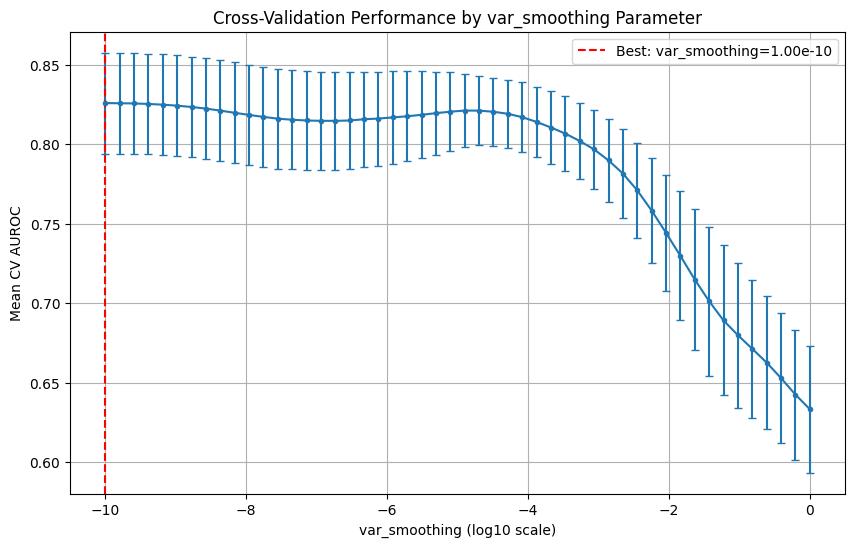

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
from tqdm import tqdm

print("Hyperparameter Tuning with 10-Fold Cross-Validation")
best_mean_auroc = 0
best_params = {}
best_model = None

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# More extensive search range for var_smoothing
var_smoothing_values = np.logspace(-10, 0, 50)  # 50 values from 1e-10 to 1

print(f"Searching for optimal hyperparameters across {len(var_smoothing_values)} values...")

# Use tqdm for progress tracking
for var_smoothing in tqdm(var_smoothing_values):
    # List to store AUROC scores for each fold
    fold_aurocs = []
    
    # Perform cross-validation
    for train_idx, val_idx in cv.split(X_train, y_train):
        # Split data for this fold
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        # Create and train Gaussian Naïve Bayes model with current parameters
        current_gnb = GaussianNB(var_smoothing=var_smoothing)
        current_gnb.fit(X_fold_train, y_fold_train)
        
        # Evaluate on validation fold using AUROC
        val_probas = current_gnb.predict_proba(X_fold_val)[:, 1]  # Get positive class probabilities
        auroc_val = roc_auc_score(y_fold_val, val_probas)
        fold_aurocs.append(auroc_val)
    
    # Calculate mean and standard deviation across folds
    mean_auroc = np.mean(fold_aurocs)
    std_auroc = np.std(fold_aurocs)
    
    print(f"Parameters: var_smoothing={var_smoothing:.2e}, CV AUROC={mean_auroc:.4f} ± {std_auroc:.4f}")
    
    # Track best model based on mean AUROC
    if mean_auroc > best_mean_auroc:
        best_mean_auroc = mean_auroc
        best_params = {'var_smoothing': var_smoothing}

# Train final model with best parameters on the full training set
best_model = GaussianNB(**best_params)
best_model.fit(X_train, y_train)

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Validation AUROC: {best_mean_auroc:.4f}")

# If you want to evaluate the best model on a test set (if available)
if 'X_test' in locals() and 'y_test' in locals():
    test_probas = best_model.predict_proba(X_test)[:, 1]
    test_auroc = roc_auc_score(y_test, test_probas)
    print(f"Test set AUROC for best model: {test_auroc:.4f}")

# Save the best model
import joblib
joblib.dump(best_model, 'best_gnb_model.pkl')
print("Best model saved as 'best_gnb_model.pkl'")

# Optionally, plot the performance curve
import matplotlib.pyplot as plt
# Collect performance data
auroc_means = []
auroc_stds = []

for var_smoothing in var_smoothing_values:
    fold_aurocs = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        # Split data for this fold
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        gnb = GaussianNB(var_smoothing=var_smoothing)
        gnb.fit(X_fold_train, y_fold_train)
        
        val_probas = gnb.predict_proba(X_fold_val)[:, 1]
        auroc_val = roc_auc_score(y_fold_val, val_probas)
        fold_aurocs.append(auroc_val)
    
    auroc_means.append(np.mean(fold_aurocs))
    auroc_stds.append(np.std(fold_aurocs))

plt.figure(figsize=(10, 6))
plt.errorbar(np.log10(var_smoothing_values), auroc_means, yerr=auroc_stds, fmt='-o', markersize=3, capsize=3)
plt.axvline(x=np.log10(best_params['var_smoothing']), color='r', linestyle='--', 
            label=f'Best: var_smoothing={best_params["var_smoothing"]:.2e}')
plt.xlabel('var_smoothing (log10 scale)')
plt.ylabel('Mean CV AUROC')
plt.title('Cross-Validation Performance by var_smoothing Parameter')
plt.grid(True)
plt.legend()
plt.savefig('gnb_cv_performance.png')
plt.show()

# Use the best model found
clf = best_model

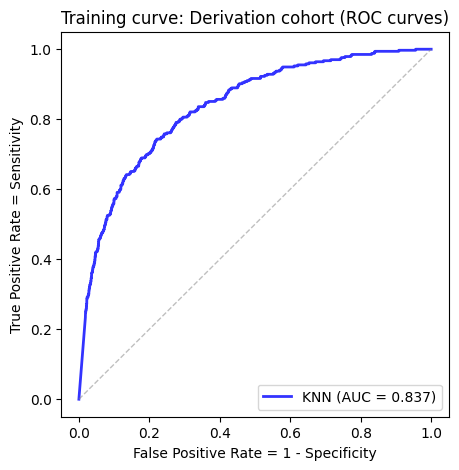

Training AUROC: 0.837 (95% CI: 0.814, 0.858)


In [17]:
# Predict on training data
pred_probas_train = clf.predict_proba(X_train)
risk_groups_train = results(pred_probas_train)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_train, auroc_ci_upper_train = bootstrap_metric_ci(y_train, pred_probas_train[:,1], "auroc")

print(f"Training AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_train:.3f}, {auroc_ci_upper_train:.3f})")


Val


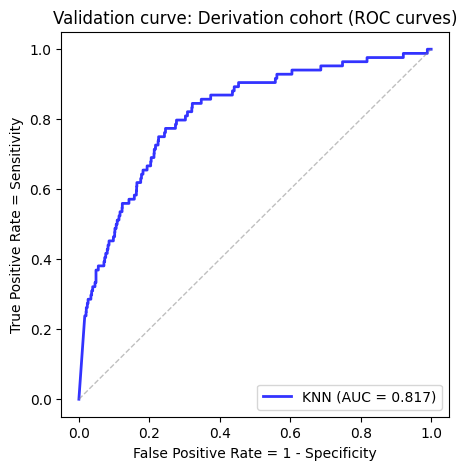

Val AUROC: 0.817 (95% CI: 0.766, 0.863)


In [18]:
# Evaluate on validation set
print("\nVal")
pred_probas_val = clf.predict_proba(X_val)
risk_groups_val = results(pred_probas_val)

# Compute ROC curve and area under the curve for validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, pred_probas_val[:,1])
roc_auc_val = auc(fpr_val, tpr_val)
plot_ROC_curve(fpr_val, tpr_val, roc_auc_val, 'Validation curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_val, auroc_ci_upper_val = bootstrap_metric_ci(y_val, pred_probas_val[:,1], "auroc")

print(f"Val AUROC: {roc_auc_val:.3f} (95% CI: {auroc_ci_lower_val:.3f}, {auroc_ci_upper_val:.3f})")